In [0]:
!pip install -q tensorflow==2.0.0-beta1 tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 87.9MB 1.7MB/s 
     |████████████████████████████████| 348.9MB 45kB/s 
     |████████████████████████████████| 3.1MB 31.7MB/s 
     |████████████████████████████████| 501kB 41.7MB/s 


In [0]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [0]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
download_file_from_google_drive('1dNsQjQYEoGXpX_w7bifHuRxFhlDejwbr','/content/data.zip')

In [0]:
!unzip -q '/content/data.zip'

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=15,
    validation_split =0.2)


test_datagen = ImageDataGenerator(
    rescale=1./255, 
  )


In [0]:
train_generator = train_datagen.flow_from_directory(
    '/content/Dataset/',
    target_size=(28, 28),
    batch_size=128,
    color_mode = 'grayscale',
    shuffle = True,
    class_mode='categorical',
    subset = 'training',
 )

valid_generator = train_datagen.flow_from_directory(
    directory="/content/Dataset/",
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=128,
    class_mode="categorical",
    shuffle=True,
    subset = "validation",
)

Found 19200 images belonging to 24 classes.
Found 4800 images belonging to 24 classes.


In [0]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input,Dense,Dropout
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten

In [0]:
#Network Parameters
input_shape = (28,28,1)
kernel_size = 3
filters = 64
dropout = 0.3

In [0]:
#user functional API to build CNN Layers

inputs = Input(shape=input_shape)
x = Conv2D(filters = filters,
           kernel_size = kernel_size,
           activation = 'relu')(inputs)
x = MaxPooling2D()(x)
x = Conv2D(filters = filters,
           kernel_size = kernel_size,
           activation = 'relu')(x)

#image to vector before connecting to dense layer

x = Flatten()(x)

#dropout regularization

x = Dropout(dropout)(x)

outputs = Dense(24, activation = 'softmax')(x)

In [0]:
model = Model(inputs = inputs, outputs = outputs)

In [0]:
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7744)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1858

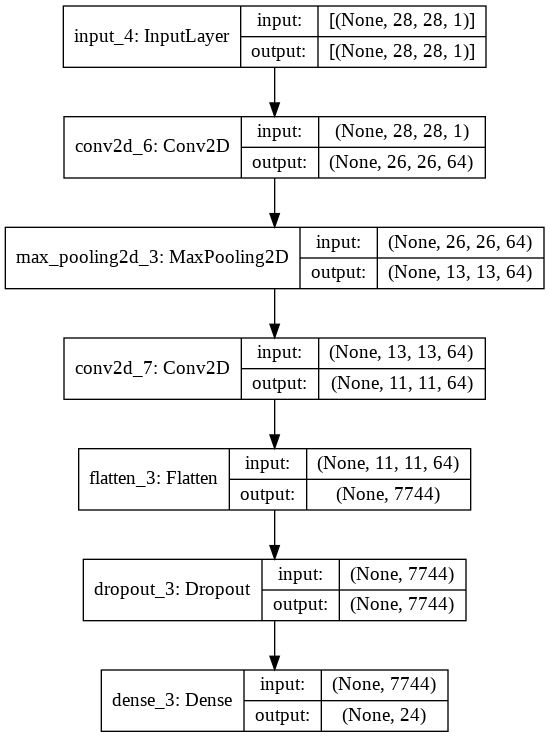

In [0]:
# Convolutional Neural Network
from tensorflow.python.keras.utils import plot_model
plot_model(model, to_file='convolution_neural_network.png',show_shapes = True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-07-29 08:58:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.145.109, 54.152.127.232, 52.73.84.118, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.145.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  12.98M  14.4MB/s    in 0.9s    

2019-07-29 08:58:04 (14.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


In [0]:
!mkdir log_dir

In [0]:
log_dir='log_dir'

In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [0]:
get_ipython().system_raw('./ngrok authtoken 3B7pn9NBtoPA5qBzWAnxC_MJtkbzVtAKAiSEKrUQKQ &')
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://675ebfdc.ngrok.io


In [0]:
from tensorflow.python.keras.callbacks import TensorBoard

In [0]:
callbacks = [TensorBoard(log_dir, update_freq='batch')]

In [0]:
model.fit_generator(train_generator,epochs = 200, steps_per_epoch=19200//128,validation_steps=4800//128,validation_data=valid_generator, callbacks=callbacks)

Epoch 1/200
150/150 [==============================] - 16s 104ms/step - loss: 0.5916 - acc: 0.8110 - val_loss: 0.5061 - val_acc: 0.8408
Epoch 2/200
150/150 [==============================] - 15s 98ms/step - loss: 0.2921 - acc: 0.9084 - val_loss: 0.3469 - val_acc: 0.8953
Epoch 3/200
150/150 [==============================] - 15s 98ms/step - loss: 0.1993 - acc: 0.9384 - val_loss: 0.2755 - val_acc: 0.9198
Epoch 4/200
150/150 [==============================] - 15s 99ms/step - loss: 0.1571 - acc: 0.9495 - val_loss: 0.2454 - val_acc: 0.9267
Epoch 5/200
150/150 [==============================] - 15s 99ms/step - loss: 0.1315 - acc: 0.9579 - val_loss: 0.2411 - val_acc: 0.9318
Epoch 6/200
150/150 [==============================] - 15s 98ms/step - loss: 0.1133 - acc: 0.9638 - val_loss: 0.2084 - val_acc: 0.9400
Epoch 7/200
150/150 [==============================] - 15s 98ms/step - loss: 0.0975 - acc: 0.9692 - val_loss: 0.1812 - val_acc: 0.9468
Epoch 8/200
150/150 [==============================] -

In [0]:
model.save('majorProjectV1.h5')

In [0]:
from google.colab import drive
drive.mount('/content/drive')